In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from scipy.stats import pearsonr, chi2_contingency
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# WiDS Datathon 2025: ADHD and Sex Prediction

**Goal:** Build a multi-outcome model to predict:
1. ADHD diagnosis (ADHD_Outcome: 0=Other/None, 1=ADHD)
2. Sex (Sex_F: 0=Male, 1=Female)

## Data Loading and Preprocessing

In [4]:
base_path = "/Users/ashly/Desktop/widsdata"
train_cat_path      = "/Users/ashly/Desktop/widsdata/TRAIN_CATEGORICAL_METADATA_new.csv"
train_fcm_path      = "/Users/ashly/Desktop/widsdata/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv"
train_quant_path    = "/Users/ashly/Desktop/widsdata/TRAIN_QUANTITATIVE_METADATA_new.csv"
train_solution_path = "/Users/ashly/Desktop/widsdata/TRAINING_SOLUTIONS.csv"

# Load the training solutions file
test_cat_path   = "/Users/ashly/Desktop/widsdata/TEST_CATEGORICAL.xlsx"
test_fcm_path   = "/Users/ashly/Desktop/widsdata/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv"
test_quant_path = "/Users/ashly/Desktop/widsdata/TEST_QUANTITATIVE_METADATA.xlsx"

In [5]:
def read_data(path_str):
    """
    Read a CSV or Excel file using pandas, handling Windows/Mac paths.
    """
    path = Path(path_str)
    if path.suffix.lower() in ['.csv']:
        return pd.read_csv(path)
    elif path.suffix.lower() in ['.xlsx', '.xls']:
        return pd.read_excel(path)
    else:
        raise ValueError(f"Unsupported file extension: {path.suffix}")

In [6]:
# Load training data
train_cat = read_data(train_cat_path)
train_fcm = read_data(train_fcm_path)
train_quant = read_data(train_quant_path)
train_solution = read_data(train_solution_path)

# Load test data
test_cat = read_data(test_cat_path)
test_fcm = read_data(test_fcm_path)
test_quant = read_data(test_quant_path)

In [7]:
print("Training shapes:", train_cat.shape, train_fcm.shape, train_quant.shape)
print("Test shapes:", test_cat.shape, test_fcm.shape, test_quant.shape)

Training shapes: (1213, 10) (1213, 19901) (1213, 19)
Test shapes: (304, 10) (304, 19901) (304, 19)


In [8]:
print("Train_Categorical")
train_cat.head()

Train_Categorical


,participant_id,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ
0,00aIpNTbG5uh,2019,4,1.0,0.0,3.0,21.0,45.0,NaN,NaN
1,00fV0OyyoLfw,2017,1,0.0,9.0,2.0,21.0,0.0,21.0,45.0
2,04X1eiS79T4B,2017,1,1.0,2.0,2.0,9.0,0.0,NaN,NaN
3,05ocQutkURd6,2018,1,3.0,8.0,2.0,18.0,10.0,18.0,0.0
4,06YUNBA9ZRLq,2018,1,0.0,1.0,2.0,12.0,0.0,NaN,NaN


In [9]:
print("Train_FCM")
train_fcm.head()

Train_FCM


,participant_id,0throw_1thcolumn,0throw_2thcolumn,0throw_3thcolumn,0throw_4thcolumn,0throw_5thcolumn,0throw_6thcolumn,0throw_7thcolumn,0throw_8thcolumn,0throw_9thcolumn,...,195throw_196thcolumn,195throw_197thcolumn,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn
0,70z8Q2xdTXM3,0.222930,0.527903,0.429966,0.060457,0.566489,0.315342,0.508408,-0.078290,0.525692,...,0.224985,0.397448,0.422966,0.184642,0.305549,0.420349,0.016328,0.561864,0.471170,0.365221
1,WHWymJu6zNZi,0.614765,0.577255,0.496127,0.496606,0.404686,0.439724,0.122590,-0.085452,0.120673,...,0.217546,-0.014549,0.000440,-0.096451,0.454501,0.343916,0.167313,0.607656,0.550623,0.503176
2,4PAQp1M6EyAo,-0.116833,0.458408,0.260703,0.639031,0.769337,0.442528,0.637110,0.192010,0.520379,...,0.342487,-0.021141,-0.037836,0.075069,0.412712,0.292708,0.391005,0.461544,0.508912,0.624232
3,obEacy4Of68I,0.199688,0.752714,0.658283,0.575096,0.692867,0.645789,0.522750,0.412188,0.530843,...,0.103562,-0.178313,0.210983,-0.018666,0.436313,0.592982,0.216205,0.341272,0.440313,0.558193
4,s7WzzDcmDOhF,0.227321,0.613268,0.621447,0.562673,0.736709,0.589813,0.266676,0.359668,0.300771,...,-0.164956,0.007064,-0.120904,-0.488095,0.493575,-0.215361,0.210685,0.055850,0.119065,0.108273


In [10]:
print("Train_Quant")
train_quant.head()

Train_Quant


,participant_id,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
0,00aIpNTbG5uh,100.00,13.0,3.0,15.0,44.0,14.0,20.0,27.0,3.0,17.0,4.0,11.0,5.0,8.0,6.0,2.0,9.0,14.274127
1,00fV0OyyoLfw,92.27,14.0,3.0,12.0,35.0,25.0,28.0,30.0,5.0,20.0,4.0,13.0,5.0,8.0,7.0,3.0,8.0,NaN
2,04X1eiS79T4B,86.67,14.0,3.0,21.0,37.0,18.0,26.0,28.0,3.0,24.0,7.0,10.0,10.0,7.0,14.0,7.0,7.0,13.463381
3,05ocQutkURd6,93.34,14.0,3.0,11.0,42.0,15.0,20.0,28.0,0.0,5.0,0.0,3.0,0.0,3.0,2.0,2.0,6.0,9.572553
4,06YUNBA9ZRLq,0.00,14.0,8.0,12.0,35.0,22.0,12.0,24.0,6.0,23.0,7.0,15.0,8.0,9.0,8.0,1.0,4.0,6.654574


In [11]:
print("Train_solutions")
train_solution.head()

Train_solutions


,participant_id,ADHD_Outcome,Sex_F
0,UmrK0vMLopoR,1,1
1,CPaeQkhcjg7d,1,0
2,Nb4EetVPm3gs,1,0
3,p4vPhVu91o4b,1,1
4,M09PXs7arQ5E,1,1


In [12]:
print("Test_Categorical")
test_cat.head()

Test_Categorical


,participant_id,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ
0,Cfwaf5FX7jWK,2022,4,0.0,0.0,4,21.0,30.0,18.0,30.0
1,vhGrzmvA3Hjq,2023,4,0.0,0.0,4,21.0,45.0,NaN,30.0
2,ULliyEXjy4OV,2022,4,0.0,0.0,4,21.0,40.0,18.0,40.0
3,LZfeAb1xMtql,2022,4,0.0,0.0,3,21.0,45.0,21.0,45.0
4,EnFOUv0YK1RG,2022,4,2.0,0.0,4,18.0,0.0,21.0,45.0


In [13]:
print("Test_FCM")
test_fcm.head()

Test_FCM


,participant_id,0throw_1thcolumn,0throw_2thcolumn,0throw_3thcolumn,0throw_4thcolumn,0throw_5thcolumn,0throw_6thcolumn,0throw_7thcolumn,0throw_8thcolumn,0throw_9thcolumn,...,195throw_196thcolumn,195throw_197thcolumn,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn
0,Cfwaf5FX7jWK,0.548480,0.713607,0.557319,0.524369,0.693364,0.770032,0.724406,0.390118,0.547912,...,0.080423,-0.054581,-0.088163,-0.028574,0.444847,0.350149,-0.012601,0.665750,0.560565,0.555732
1,vhGrzmvA3Hjq,0.427740,0.363022,0.402862,0.363003,0.534558,0.345347,0.409471,0.303328,0.402515,...,0.198009,-0.000724,0.083122,0.033043,0.687497,0.306229,0.717485,0.461809,0.559632,0.350027
2,ULliyEXjy4OV,0.139572,0.390106,-0.087041,0.196852,0.088148,0.023843,0.381782,0.068979,0.377488,...,0.051319,0.023630,-0.056819,0.117396,0.576086,0.517831,0.527044,0.605038,0.609856,0.750987
3,LZfeAb1xMtql,0.133561,0.778326,0.416355,0.471840,0.568460,0.633660,0.501113,0.345461,0.467943,...,0.046183,-0.238962,0.121868,-0.260970,0.646818,0.594902,0.608156,0.595459,0.683189,0.542296
4,EnFOUv0YK1RG,0.126699,0.575446,0.509422,0.363193,0.427544,0.449924,0.451796,0.223927,0.298248,...,0.315734,0.002234,0.290791,0.344149,0.480214,0.539824,0.447322,0.293088,0.148529,0.539823


In [14]:
print("Test_Quant")
test_quant.head()

Test_Quant


,participant_id,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
0,Cfwaf5FX7jWK,60.03,14.0,5.0,16.0,41.0,19.0,11.0,26.0,2.0,12.0,3.0,9.0,2.0,7.0,3.0,0.0,8.0,8.992813
1,vhGrzmvA3Hjq,86.71,12.0,3.0,13.0,43.0,18.0,15.0,28.0,2.0,16.0,8.0,5.0,7.0,3.0,11.0,3.0,9.0,12.324093
2,ULliyEXjy4OV,26.68,13.0,3.0,14.0,36.0,16.0,14.0,25.0,1.0,7.0,1.0,6.0,1.0,5.0,1.0,0.0,9.0,7.770933
3,LZfeAb1xMtql,93.38,13.0,3.0,19.0,41.0,17.0,18.0,27.0,4.0,15.0,4.0,10.0,8.0,6.0,5.0,1.0,6.0,9.304814
4,EnFOUv0YK1RG,-93.38,14.0,3.0,13.0,42.0,19.0,16.0,28.0,2.0,18.0,6.0,12.0,5.0,10.0,6.0,0.0,10.0,8.261350


In [15]:
# Merge by participant_id
train_merged = (
    train_cat
    .merge(train_fcm, on="participant_id", how="inner")
    .merge(train_quant, on="participant_id", how="inner")
)

test_merged = (
    test_cat
    .merge(test_fcm, on="participant_id", how="inner")
    .merge(test_quant, on="participant_id", how="inner")
)

print("Merged train shape:", train_merged.shape)
print("Merged test shape:", test_merged.shape)

Merged train shape: (1213, 19928)
Merged test shape: (304, 19928)


# Missing Value Handling

In [17]:
# Calculate missing fraction in training
missing_frac = train_merged.isnull().mean()
cols_high_missing = missing_frac[missing_frac > 0.10].index.tolist()
print(f"Dropping {len(cols_high_missing)} cols >10% missing:\n", cols_high_missing)

# Drop these columns in both train and test
train_clean = train_merged.drop(columns=cols_high_missing)
test_clean = test_merged.drop(columns=cols_high_missing, errors='ignore')

Dropping 3 cols >10% missing:
 ['Barratt_Barratt_P2_Edu', 'Barratt_Barratt_P2_Occ', 'MRI_Track_Age_at_Scan']


In [18]:
# Numeric impute
num_cols = train_clean.select_dtypes(include=[np.number]).columns
imp_num = SimpleImputer(strategy='median')
train_clean[num_cols] = imp_num.fit_transform(train_clean[num_cols])
test_clean[num_cols]  = imp_num.transform(test_clean[num_cols])

# Drop categorical NA
cat_cols = train_clean.select_dtypes(include=['object', 'category']).columns
train_clean = train_clean.dropna(subset=cat_cols)
test_clean  = test_clean.dropna(subset=cat_cols)

print("Post‑clean train shape:", train_clean.shape)
print("Post‑clean test shape:", test_clean.shape)

Post‑clean train shape: (1213, 19925)
Post‑clean test shape: (304, 19925)


# Merge Targets & Split Features/Labels

In [20]:
train_data = train_clean.merge(
    train_solution[['participant_id','ADHD_Outcome','Sex_F']],
    on='participant_id', how='inner'
)

X_train = train_data.drop(['participant_id','ADHD_Outcome','Sex_F'], axis=1)
y_train = train_data[['ADHD_Outcome','Sex_F']]

# Correlation Analysis (Top 20)

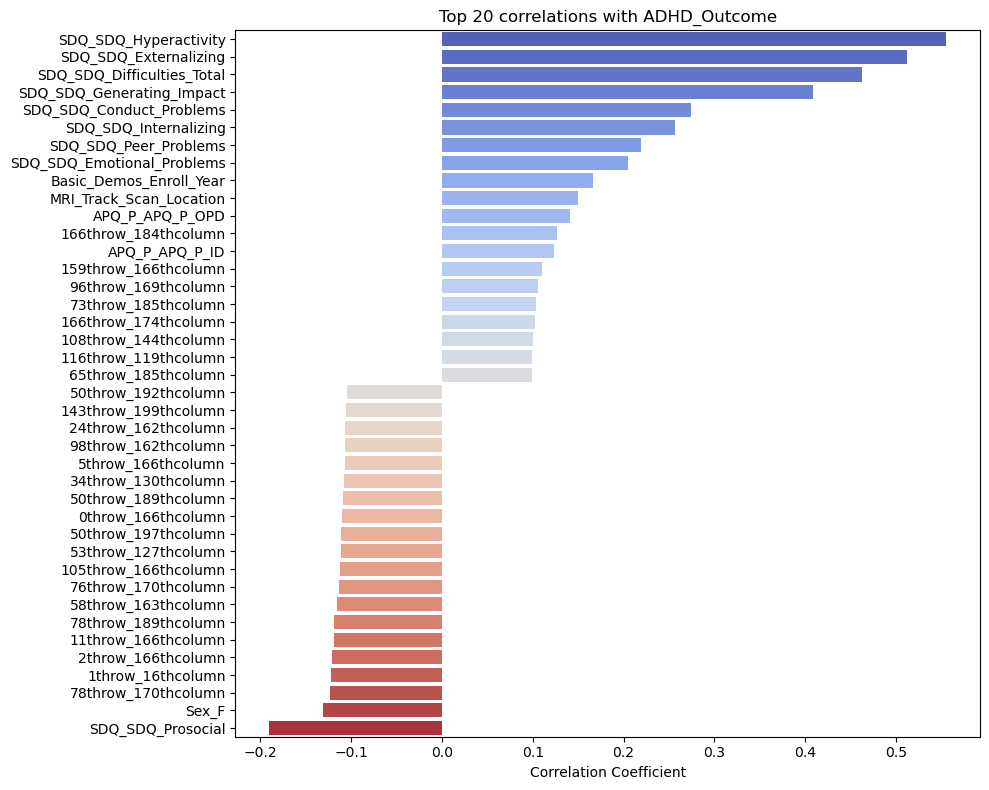

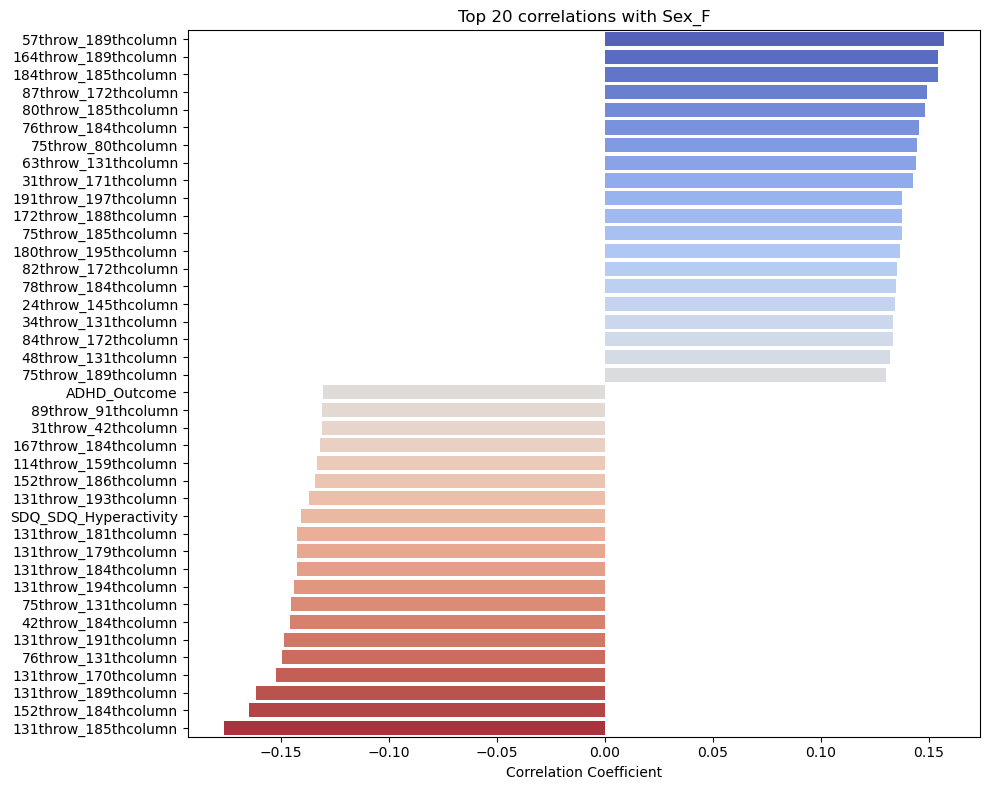

In [22]:
def analyze_correlations(df, target, top_n=20):
    df_num = df.select_dtypes(include=[np.number]).copy()
    df_num = df_num.fillna(df_num.median())
    corr_all = df_num.corrwith(df_num[target])
    corr_sorted = corr_all.drop(target).sort_values(ascending=False)
    top_and_bottom = pd.concat([corr_sorted.head(top_n), corr_sorted.tail(top_n)])
    plt.figure(figsize=(10,8))
    sns.barplot(x=top_and_bottom.values, y=top_and_bottom.index, palette="coolwarm")
    plt.title(f"Top {top_n} correlations with {target}")
    plt.xlabel("Correlation Coefficient")
    plt.tight_layout()
    plt.show()
    return corr_all

corr_adhd = analyze_correlations(train_data, 'ADHD_Outcome', top_n=20)
corr_sex = analyze_correlations(train_data, 'Sex_F',      top_n=20)

# Mutual Information Analysis (Top 20)

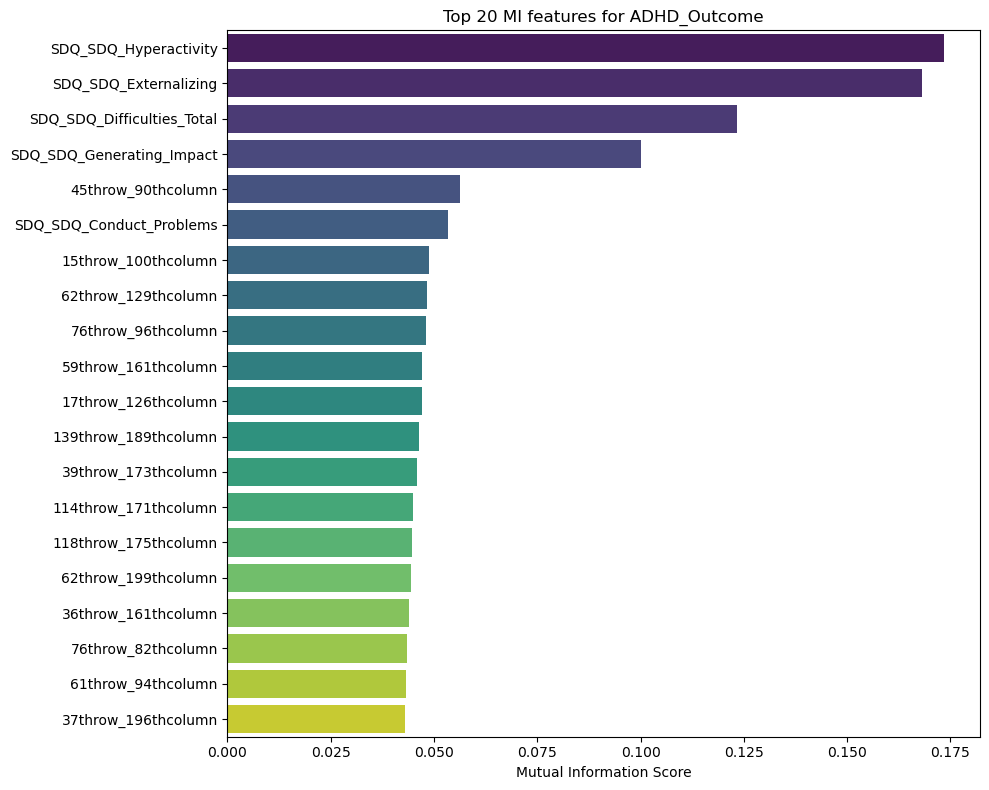

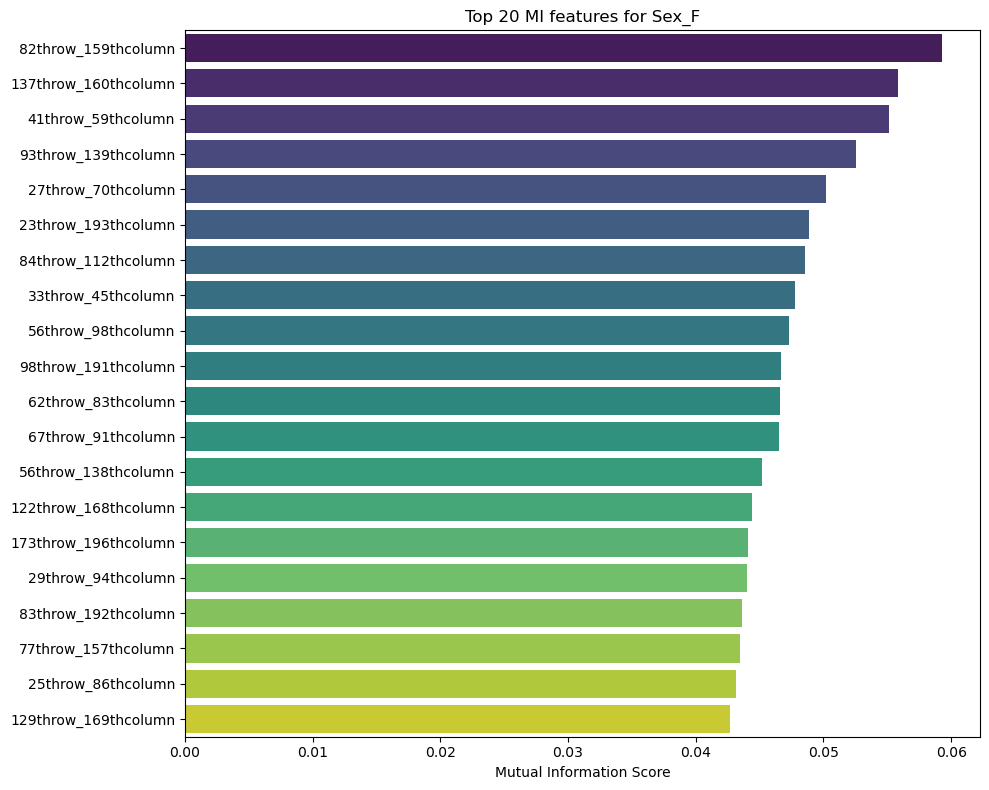

In [24]:
def analyze_mi(df, target, top_n=20):
    X = df.drop(['participant_id', 'ADHD_Outcome', 'Sex_F'], axis=1).copy()
    y = df[target]
    # Factorize categoricals
    for col in X.select_dtypes(include=['object', 'category']):
        X[col] = pd.factorize(X[col])[0]
    X = X.fillna(X.median())
    mi_scores = mutual_info_classif(X, y)
    mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
    plt.figure(figsize=(10,8))
    sns.barplot(x=mi_series.head(top_n).values, y=mi_series.head(top_n).index, palette="viridis")
    plt.title(f"Top {top_n} MI features for {target}")
    plt.xlabel("Mutual Information Score")
    plt.tight_layout()
    plt.show()
    return mi_series

mi_adhd = analyze_mi(train_data, 'ADHD_Outcome', top_n=20)
mi_sex  = analyze_mi(train_data, 'Sex_F',       top_n=20)

# PCA Dimensionality Reduction (50 Components)

In [33]:
# Identify numeric columns
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

# Compute medians locally (so we have them in this cell)
medians_local = train_clean[num_cols].median()

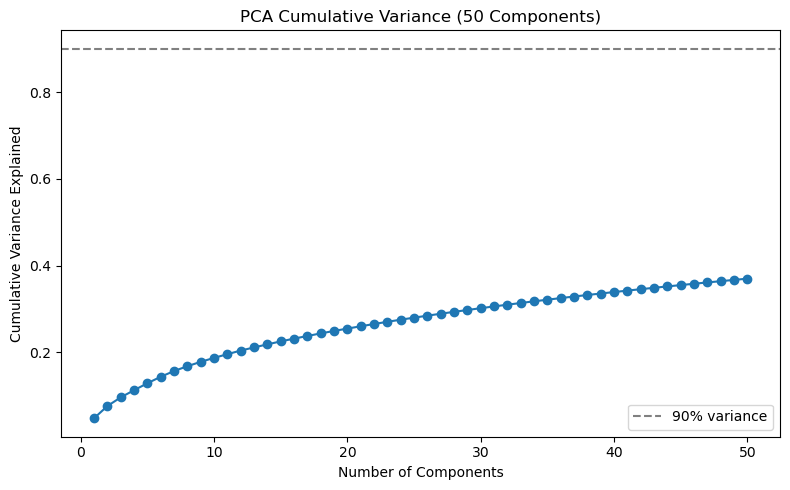

In [35]:
# Fill missing in X_train
X_num = X_train[num_cols].fillna(medians_local)

# Standardize
scaler_pca = StandardScaler().fit(X_num)
X_scaled = scaler_pca.transform(X_num)

# PCA
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_scaled)

# Plot explained variance
cumvar = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(8,5))
plt.plot(range(1,51), cumvar, marker='o')
plt.axhline(0.90, linestyle='--', color='gray', label='90% variance')
plt.title('PCA Cumulative Variance (50 Components)')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.legend()
plt.tight_layout()
plt.show()

# Prepare Test Set for Modeling

In [39]:
# Define pipelines
num_feat = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_feat = X_train.select_dtypes(include=['object','category']).columns.tolist()

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])
# Combine + PCA
full_pipeline = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('num', num_pipeline, num_feat),
        ('cat', cat_pipeline, cat_feat)
    ], remainder='drop')),
    ('pca', PCA(n_components=100))
])

# Fit & transform
X_train_processed = full_pipeline.fit_transform(X_train)
X_test_feat       = test_clean.drop(['participant_id'], axis=1)
X_test_processed  = full_pipeline.transform(X_test_feat)

print('Processed train shape:', X_train_processed.shape)
print('Processed test  shape:', X_test_processed.shape)

Processed train shape: (1213, 100)
Processed test  shape: (304, 100)
